In [1]:
from torch.distributions import Normal
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gymnasium
import imageio
import random

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.network(state)
        log_std = self.log_std.expand_as(mean)
        std = torch.exp(log_std)
        return Normal(mean, std)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [4]:
class PPO:
    def __init__(self, clip_eps):
        self.env = gymnasium.make("InvertedPendulum-v4", render_mode="rgb_array")
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]

        self.T = 2048
        self.gamma = 0.99  # discount factor
        self.lam = 0.95  # lambda for GAE
        self.num_epochs = 10
        self.minibatch_size = 64
        self.clip_eps = clip_eps
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim)
        self.val_net = ValueNetwork(self.state_dim)
        self.learning_rate = 3e-4
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.value_optimizer = optim.Adam(self.val_net.parameters(), lr=self.learning_rate)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        dist = self.policy_net(state)
        action = dist.sample().squeeze(0)
        log_prob = dist.log_prob(action).squeeze()
        return action.numpy(), log_prob

    def collect_data(self):
        states, actions, rewards, log_probs, masks = [], [], [], [], []
        episode_rewards = []
        current_episode_reward = 0
        total_timesteps = 0

        state, _ = self.env.reset(seed=seed)

        while total_timesteps < self.T:
            action, log_prob = self.select_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)

            done = terminated or truncated
            mask = 0 if done else 1

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            masks.append(mask)

            current_episode_reward += reward
            state = next_state
            total_timesteps += 1

            if done:
                episode_rewards.append(current_episode_reward)
                current_episode_reward = 0
                state, _ = self.env.reset(seed=seed)

        return states, actions, rewards, log_probs, masks, episode_rewards

    def compute_rewards_to_go(self, rewards, masks):
        rtg = []
        discounted_sum = 0
        for reward, mask in zip(reversed(rewards), reversed(masks)):
            discounted_sum = reward + self.gamma * discounted_sum * mask
            rtg.insert(0, discounted_sum)
        return torch.tensor(rtg)

    def compute_advantages(self, states, rewards, masks):
        values = self.val_net(torch.FloatTensor(states)).squeeze().detach()
        T = len(rewards)
        advantages = torch.zeros(T, dtype=torch.float32)
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = rewards[t] + self.gamma * values[t + 1] * masks[t + 1] - values[t]
            gae = td_error + self.gamma * self.lam * gae * masks[t + 1]
            advantages[t] = gae

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)
        return advantages

    def update(self, states, actions, log_probs_old, rewards_to_go, advantages):
        total_samples = len(states)
        indices = torch.randperm(total_samples)

        for _ in range(self.num_epochs):
            for i in range(0, total_samples, self.minibatch_size):
                # Extract the minibatch
                batch_indices = indices[i:i + self.minibatch_size]
                states_batch = torch.FloatTensor(states)[batch_indices]
                actions_batch = torch.FloatTensor(actions)[batch_indices]
                old_log_probs_batch = torch.FloatTensor(log_probs_old)[batch_indices]
                rewards_to_go_batch = torch.FloatTensor(rewards_to_go)[batch_indices]
                advantages_batch = torch.FloatTensor(advantages)[batch_indices]

                # Recalculate log probabilities for current policy
                dist = self.policy_net(states_batch)
                new_log_probs = dist.log_prob(actions_batch).sum(axis=-1)

                # Ratio for PPO clipping
                ratios = torch.exp(new_log_probs - old_log_probs_batch)

                # Clipped objective function
                surr1 = ratios * advantages_batch
                surr2 = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps) * advantages_batch
                policy_loss = -torch.min(surr1, surr2).mean()

                # Update policy network
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()

                # Value function loss
                value_preds = self.val_net(states_batch).squeeze()
                value_loss = (value_preds - rewards_to_go_batch).pow(2).mean()

                # Update value network
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()

    def evaluate(self):
        state, _ = self.env.reset(seed=seed)
        total_reward = 0
        done = False

        while not done:
            action, log_prob = self.select_action(state)
            state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += 1
            done = terminated or truncated

        return total_reward

    def train(self, seed):
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        rewards_over_episodes = []

        timestep = 0

        while timestep < 1000:
            states, actions, rewards, log_probs, masks, episode_rewards = self.collect_data()
            timestep += len(episode_rewards)

            rewards_to_go = self.compute_rewards_to_go(rewards, masks)
            advantages = self.compute_advantages(states, rewards, masks)
            log_probs = torch.FloatTensor(log_probs)

            self.update(states, actions, log_probs, rewards_to_go, advantages)
            rewards_over_episodes.extend(episode_rewards)

            episode_reward = self.evaluate()
            print(f"Timestep {timestep}: Reward = {episode_reward}")

        return rewards_over_episodes

In [5]:
clip_epsilons = [0.2]
seeds = [1]

results = {}
for eps in clip_epsilons:
    agent = PPO(clip_eps=eps)
    rewards_over_seeds = []
    for seed in seeds:
        rewards = agent.train(seed=seed)
        rewards_over_seeds.append(rewards)
    results[eps] = rewards_over_seeds

Timestep 229: Reward = 11
Timestep 406: Reward = 17
Timestep 543: Reward = 45
Timestep 654: Reward = 26
Timestep 722: Reward = 37
Timestep 766: Reward = 53
Timestep 813: Reward = 41
Timestep 845: Reward = 67
Timestep 871: Reward = 81
Timestep 900: Reward = 76
Timestep 922: Reward = 136
Timestep 941: Reward = 33
Timestep 956: Reward = 363
Timestep 964: Reward = 226
Timestep 970: Reward = 430
Timestep 977: Reward = 269
Timestep 984: Reward = 632
Timestep 987: Reward = 1000
Timestep 989: Reward = 1000
Timestep 991: Reward = 1000
Timestep 993: Reward = 1000
Timestep 995: Reward = 691
Timestep 997: Reward = 1000
Timestep 999: Reward = 1000
Timestep 1001: Reward = 1000


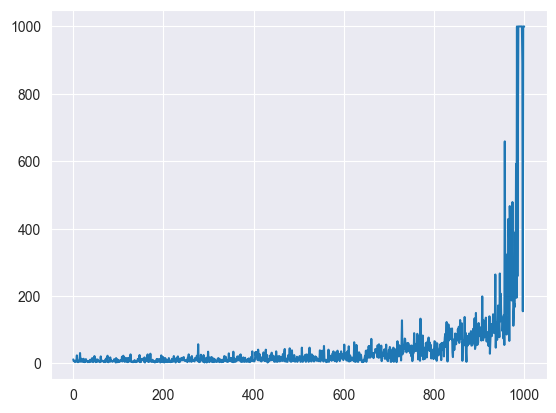

In [6]:
plt.plot(results[0.2][0])
plt.show()

In [7]:
env = gymnasium.make("InvertedPendulum-v4", render_mode="rgb_array")
frames = []

state, _ = env.reset(seed=seed)
done = False

while not done:
    action, log_prob = agent.select_action(state)

    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    frame = env.render()
    frames.append(frame)

imageio.mimsave("inverted_pendulum.gif", frames, fps=30)

env.close()